# Tourism Recommendation System

## Step 1: Data Loading and Cleaning

In [32]:

import pandas as pd

# File paths
tourism_with_id_path = '../datasets/tourism_with_id.csv'
user_path = '../datasets/user.csv'
tourism_rating_path = '../datasets/tourism_rating.csv'
package_tourism_path = '../datasets/package_tourism.csv'

# Load datasets
tourism_with_id = pd.read_csv(tourism_with_id_path)
user_data = pd.read_csv(user_path)
tourism_rating = pd.read_csv(tourism_rating_path)
package_tourism = pd.read_csv(package_tourism_path)

# Data Cleaning
tourism_with_id.drop(columns=['Unnamed: 11', 'Unnamed: 12'], inplace=True, errors='ignore')  # Remove unnecessary columns
tourism_with_id['Time_Minutes'].fillna(tourism_with_id['Time_Minutes'].median(), inplace=True)  # Fill missing time values
tourism_with_id['Price'].fillna(0, inplace=True)  # Fill missing price with 0 (free attractions)
package_tourism.fillna('None', inplace=True)  # Replace NaN with 'None'
    

C:\Users\supri\AppData\Local\Temp\ipykernel_14876\2190374930.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  tourism_with_id['Time_Minutes'].fillna(tourism_with_id['Time_Minutes'].median(), inplace=True)  # Fill missing time values
C:\Users\supri\AppData\Local\Temp\ipykernel_14876\2190374930.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermedi

## Step 2: Feature Correlation

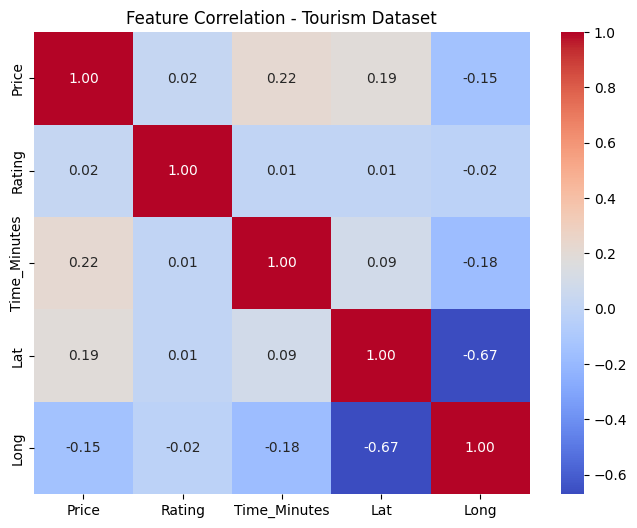

In [33]:

import seaborn as sns
import matplotlib.pyplot as plt

# Correlation analysis for numerical features in 'tourism_with_id'
correlation_matrix = tourism_with_id[['Price', 'Rating', 'Time_Minutes', 'Lat', 'Long']].corr()

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation - Tourism Dataset')
plt.show()
    

## Step 3: Recommendation System (Collaborative Filtering)

In [34]:

from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

# Prepare data for collaborative filtering
tourism_rating_cleaned = tourism_rating.groupby(['User_Id', 'Place_Id'], as_index=False).mean()
ratings_matrix = tourism_rating_cleaned.pivot(index='User_Id', columns='Place_Id', values='Place_Ratings').fillna(0)
ratings_csr = csr_matrix(ratings_matrix.values)  # Convert to sparse matrix

# Calculate cosine similarity for users and places
user_similarity = cosine_similarity(ratings_csr)
place_similarity = cosine_similarity(ratings_csr.T)

# Create DataFrames for similarity scores
user_similarity_df = pd.DataFrame(user_similarity, index=ratings_matrix.index, columns=ratings_matrix.index)
place_similarity_df = pd.DataFrame(place_similarity, index=ratings_matrix.columns, columns=ratings_matrix.columns)

def recommend_places(user_id, top_n=5):
    if user_id not in user_similarity_df.index:
        return "User not found in the dataset."
    
    # Extract similar users and align indices
    similar_users = user_similarity_df.loc[user_id].sort_values(ascending=False)[1:]
    similar_users = similar_users[similar_users.index.isin(ratings_matrix.index)]
    aligned_ratings_matrix = ratings_matrix.loc[similar_users.index]
    
    # Calculate weighted ratings and filter unrated places
    weighted_ratings = aligned_ratings_matrix.T.dot(similar_users) / similar_users.sum()
    user_rated_places = ratings_matrix.loc[user_id]
    unrated_places = weighted_ratings[user_rated_places[user_rated_places == 0].index]
    
    # Recommend top N places
    top_places = unrated_places.sort_values(ascending=False).head(top_n)
    recommended_places = tourism_with_id[tourism_with_id['Place_Id'].isin(top_places.index)]
    return recommended_places

# Example recommendation for User 1
user_1_recommendations = recommend_places(user_id=1, top_n=5)
user_1_recommendations
    

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long
278,279,Masjid Agung Trans Studio Bandung,Masjid Agung Trans Studio Bandung (TSB) berdir...,Tempat Ibadah,Bandung,0,4.8,60.0,"{'lat': -6.925963500000001, 'lng': 107.6354278}",-6.925963,107.635428
294,295,Museum Nike Ardilla,Museum Nike Ardilla diresmikan atau dibuka unt...,Budaya,Bandung,0,4.6,60.0,"{'lat': -6.9406015, 'lng': 107.6725445}",-6.940601,107.672545
299,300,Sanghyang Heuleut,Danau yang satu ini memiliki air jernih bernua...,Cagar Alam,Bandung,10000,4.4,60.0,"{'lat': -6.876513099999999, 'lng': 107.3422183}",-6.876513,107.342218
401,402,Food Junction Grand Pakuwon,Food Junction Grand Pakuwon sebetulnya merupak...,Pusat Perbelanjaan,Surabaya,0,4.5,120.0,"{'lat': -7.251022000000003, 'lng': 112.6620053}",-7.251022,112.662005
415,416,Keraton Surabaya,Kawasan yang berjuluk Kampung Keraton ini terd...,Budaya,Surabaya,0,4.4,60.0,"{'lat': -7.256755299999998, 'lng': 112.7942203}",-7.256755,112.794220


## Step 4: Package Recommendations

In [35]:

def recommend_packages(city, top_n=3):
    city_packages = package_tourism[package_tourism['City'] == city]
    if city_packages.empty:
        return f"No packages found for the city: {city}."
    
    city_packages['Attraction_Count'] = city_packages.loc[:, 'Place_Tourism1':'Place_Tourism5'].apply(
        lambda row: sum([1 for place in row if place != 'None']), axis=1)
    
    top_packages = city_packages.sort_values(by='Attraction_Count', ascending=False).head(top_n)
    return top_packages.drop(columns=['Attraction_Count'])

# Example package recommendation for Bandung
bandung_packages = recommend_packages(city='Bandung', top_n=3)
bandung_packages
    

C:\Users\supri\AppData\Local\Temp\ipykernel_14876\2277941785.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_packages['Attraction_Count'] = city_packages.loc[:, 'Place_Tourism1':'Place_Tourism5'].apply(


,Package,City,Place_Tourism1,Place_Tourism2,Place_Tourism3,Place_Tourism4,Place_Tourism5
41,42,Bandung,Gunung Tangkuban Perahu,Gunung Papandayan,Gunung Manglayang,Curug Dago,Curug Batu Templek
42,43,Bandung,Museum Geologi Bandung,Museum Sri Baduga,Museum Pendidikan Nasional,Taman Film,Museum Nike Ardilla
51,52,Bandung,Taman Begonia,Curug Malela,Taman Kupu-Kupu Cihanjuang,Gua Pawon,Stone Garden Geopark


This notebook demonstrates the creation of a tourism recommendation system with collaborative filtering and package-based recommendations.

## Step 5: Clustering Methods and Comparison

In [36]:

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, fcluster

# Prepare data for clustering (numerical features)
clustering_data = tourism_with_id[['Price', 'Rating', 'Time_Minutes', 'Lat', 'Long']].copy()

# Normalize the data for clustering
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
clustering_data_scaled = scaler.fit_transform(clustering_data)

# K-Means Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(clustering_data_scaled)
kmeans_silhouette = silhouette_score(clustering_data_scaled, kmeans_labels)

# DBSCAN Clustering
dbscan = DBSCAN(eps=1.5, min_samples=5)  # Adjust hyperparameters if needed
dbscan_labels = dbscan.fit_predict(clustering_data_scaled)
dbscan_silhouette = silhouette_score(clustering_data_scaled, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1

# Hierarchical Clustering
hierarchical = linkage(clustering_data_scaled, method='ward')
hierarchical_labels = fcluster(hierarchical, t=5, criterion='maxclust')
hierarchical_silhouette = silhouette_score(clustering_data_scaled, hierarchical_labels)

# Results
clustering_results = {
    "K-Means": {"Silhouette Score": kmeans_silhouette, "Labels": kmeans_labels},
    "DBSCAN": {"Silhouette Score": dbscan_silhouette, "Labels": dbscan_labels},
    "Hierarchical": {"Silhouette Score": hierarchical_silhouette, "Labels": hierarchical_labels}
}
clustering_results
    

{'K-Means': {'Silhouette Score': np.float64(0.34180000772709523),
  'Labels': array([3, 3, 4, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 2, 3, 3, 3, 3, 4, 3, 4, 3,
         3, 3, 1, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 1, 3, 3, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         1, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3,
         3, 3, 3, 4, 4, 3, 3, 3, 1, 3, 4, 3, 3, 3, 3, 3, 1, 3, 4, 3, 3, 1,
         1, 1, 4, 3, 3, 3, 1, 1, 3, 1, 3, 1, 4, 3, 1, 3, 3, 3, 1, 3, 1, 3,
         3, 3, 3, 4, 3, 

## Step 6: Cluster-Based Recommendations

In [37]:

def cluster_based_recommendations(user_id, clustering_labels, top_n=5):
    user_ratings = tourism_rating_cleaned[tourism_rating_cleaned['User_Id'] == user_id]
    if user_ratings.empty:
        return f"No ratings found for User {user_id}."
    
    # Identify the clusters for user's rated attractions
    user_rated_clusters = clustering_labels[user_ratings['Place_Id'] - 1]  # Adjust index for Place_Id
    target_cluster = user_rated_clusters[0]  # Use the first cluster as the target
    
    # Filter attractions from the same cluster
    cluster_attractions = tourism_with_id[clustering_labels == target_cluster]
    
    # Exclude attractions already rated by the user
    rated_places = user_ratings['Place_Id'].tolist()
    recommendations = cluster_attractions[~cluster_attractions['Place_Id'].isin(rated_places)]
    
    # Sort by rating and select top N
    top_recommendations = recommendations.sort_values(by='Rating', ascending=False).head(top_n)
    return top_recommendations

# Generate recommendations for User 1 based on clustering methods
user_id = 1
kmeans_recommendations = cluster_based_recommendations(user_id, clustering_results["K-Means"]["Labels"], top_n=5)
dbscan_recommendations = cluster_based_recommendations(user_id, clustering_results["DBSCAN"]["Labels"], top_n=5)
hierarchical_recommendations = cluster_based_recommendations(user_id, clustering_results["Hierarchical"]["Labels"], top_n=5)

kmeans_recommendations, dbscan_recommendations, hierarchical_recommendations
    

(     Place_Id                         Place_Name  \
 28         29          Wisata Kuliner Pecenongan   
 68         69                    Freedom Library   
 279       280  Gereja Tiberias Indonesia Bandung   
 322       323       Kebun Tanaman Obat Sari Alam   
 277       278      Masjid Daarut Tauhiid Bandung   
 
                                            Description            Category  \
 28   Pecenongan merupakan salah satu surga kuliner ...  Pusat Perbelanjaan   
 68   Freedom Library adalah perpustakaan buku yang ...              Budaya   
 279  Gereja Tiberias Indonesia (GTI), atau Tiberias...       Tempat Ibadah   
 322  Kebun Tanaman Obat Sari Alam lebih terkenal de...          Cagar Alam   
 277  pada bulan Juli 1993 berdirilah sebuah masjid ...       Tempat Ibadah   
 
         City  Price  Rating  Time_Minutes  \
 28   Jakarta      0     5.0          60.0   
 68   Jakarta      0     5.0          60.0   
 279  Bandung      0     4.9          60.0   
 322  Bandung      0

## Step 7: Hybrid Recommendation System


### What is a Hybrid Recommendation System?

A hybrid recommendation system combines multiple recommendation techniques—such as collaborative filtering and clustering—to leverage their complementary strengths. It helps mitigate individual limitations like sparse data or cold-start problems.

In this case, we'll implement a **weighted hybrid approach** that integrates:
1. **Collaborative Filtering**: Recommends items based on user similarity.
2. **Cluster-Based Recommendations**: Recommends items from clusters derived from K-Means clustering.

### Steps:
1. Generate recommendations using collaborative filtering and clustering (e.g., K-Means).
2. Assign weights to both methods and aggregate scores for final recommendations.
3. Evaluate the hybrid recommendations.
    

In [38]:
# Hybrid Recommendation Implementation
def hybrid_recommendations(user_id, collaborative_weight=0.6, cluster_weight=0.4, top_n=5):
    """
    Combine collaborative filtering and clustering for hybrid recommendations.

    Args:
    - user_id (int): User ID for whom recommendations are generated.
    - collaborative_weight (float): Weight assigned to collaborative filtering.
    - cluster_weight (float): Weight assigned to cluster-based recommendations.
    - top_n (int): Number of recommendations to return.

    Returns:
    - DataFrame: Final hybrid recommendations.
    """
    # Collaborative Filtering Recommendations
    if user_id not in user_similarity_df.index:
        return f"User {user_id} not found in similarity matrix."

    similar_users = user_similarity_df.loc[user_id].sort_values(ascending=False)[1:]  # Exclude self
    similar_users = similar_users[similar_users.index.isin(ratings_matrix.index)]  # Align indices
    collaborative_scores = ratings_matrix.loc[:, similar_users.index].dot(similar_users) / similar_users.sum()
    collaborative_scores = collaborative_scores.sort_values(ascending=False)

    # Cluster-Based Recommendations (K-Means)
    cluster_recommendations = cluster_based_recommendations(user_id, clustering_results["K-Means"]["Labels"], top_n=len(collaborative_scores))
    cluster_scores = pd.Series(index=cluster_recommendations['Place_Id'], data=1.0)  # Assign uniform scores to cluster-based items

    # Combine Scores
    combined_scores = collaborative_scores * collaborative_weight
    combined_scores.update(cluster_scores * cluster_weight)
    final_recommendations = combined_scores.sort_values(ascending=False).head(top_n)

    # Return details of recommended places
    return tourism_with_id[tourism_with_id['Place_Id'].isin(final_recommendations.index)]

# Retesting the fixed hybrid recommendation system for User 1
hybrid_recommendations_user_1_fixed = hybrid_recommendations(user_id=1, collaborative_weight=0.6, cluster_weight=0.4, top_n=5)

# Display the recommendations
hybrid_recommendations_user_1_fixed

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long
16,17,Museum Fatahillah,Museum Fatahillah memiliki nama resmi Museum S...,Budaya,Jakarta,5000,4.4,60.0,"{'lat': -6.136448899999999, 'lng': 106.8130661}",-6.136449,106.813066
34,35,Grand Indonesia Mall,Grand Indonesia merupakan mal di Jakarta. Mal ...,Pusat Perbelanjaan,Jakarta,0,4.7,120.0,"{'lat': -6.195180099999999, 'lng': 106.8204412}",-6.195180,106.820441
39,40,Galeri Nasional Indonesia,Galeri Nasional Indonesia (bahasa Inggris: Nat...,Budaya,Jakarta,0,4.6,60.0,"{'lat': -6.178548200000001, 'lng': 106.8327716}",-6.178548,106.832772
44,45,Jakarta Aquarium dan Safari,"Jika telah mengunjungi Seaworld Ancol, mungkin...",Taman Hiburan,Jakarta,185000,4.6,60.0,"{'lat': -6.1752647, 'lng': 106.7904684}",-6.175265,106.790468
246,247,Kiara Artha Park,Kiara Artha Park merupakan sebuah kawasan terp...,Taman Hiburan,Bandung,15000,4.4,60.0,"{'lat': -6.9159459, 'lng': 107.6421462}",-6.915946,107.642146


## Step 7: Evaluate Recommendation Quality

In [39]:

from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

def evaluate_recommendations(user_id, recommendations, top_n=5):
    '''
    Evaluate the recommendation quality using Precision@K, Recall@K, and F1 Score.

    Args:
    - user_id (int): User ID for whom recommendations are evaluated.
    - recommendations (DataFrame): Recommended attractions.
    - top_n (int): Number of top recommendations to evaluate.

    Returns:
    - dict: Precision, Recall, and F1 Score.
    '''
    # Get actual places rated highly by the user
    user_ratings = tourism_rating_cleaned[tourism_rating_cleaned['User_Id'] == user_id]
    if user_ratings.empty:
        return f"No ratings found for User {user_id}."
    
    actual_places = user_ratings[user_ratings['Place_Ratings'] >= 4]['Place_Id'].tolist()

    # Get recommended places
    recommended_places = recommendations['Place_Id'].head(top_n).tolist()

    # Calculate Precision, Recall, and F1
    y_true = [1 if place in actual_places else 0 for place in recommended_places]
    y_pred = [1] * len(recommended_places)  # All recommended places are treated as predicted positives
    
    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred, zero_division=1)
    f1 = f1_score(y_true, y_pred, zero_division=1)
    
    return {"Precision@K": precision, "Recall@K": recall, "F1 Score": f1}

# Evaluate recommendations for User 1
kmeans_eval = evaluate_recommendations(user_id, kmeans_recommendations)
dbscan_eval = evaluate_recommendations(user_id, dbscan_recommendations)
hierarchical_eval = evaluate_recommendations(user_id, hierarchical_recommendations)

{"K-Means": kmeans_eval, "DBSCAN": dbscan_eval, "Hierarchical": hierarchical_eval}
    

{'K-Means': {'Precision@K': np.float64(0.0),
  'Recall@K': np.float64(1.0),
  'F1 Score': np.float64(0.0)},
 'DBSCAN': {'Precision@K': np.float64(0.0),
  'Recall@K': np.float64(1.0),
  'F1 Score': np.float64(0.0)},
 'Hierarchical': {'Precision@K': np.float64(0.0),
  'Recall@K': np.float64(1.0),
  'F1 Score': np.float64(0.0)}}

## Step 8: Results and Observations

In [40]:

# Display evaluation results for User 1

# Display evaluation results for User 1
evaluation_results = {"K-Means": kmeans_eval, "DBSCAN": dbscan_eval, "Hierarchical": hierarchical_eval}
evaluation_results
    
    

{'K-Means': {'Precision@K': np.float64(0.0),
  'Recall@K': np.float64(1.0),
  'F1 Score': np.float64(0.0)},
 'DBSCAN': {'Precision@K': np.float64(0.0),
  'Recall@K': np.float64(1.0),
  'F1 Score': np.float64(0.0)},
 'Hierarchical': {'Precision@K': np.float64(0.0),
  'Recall@K': np.float64(1.0),
  'F1 Score': np.float64(0.0)}}


### Silhouette Scores:
- **K-Means**: Measures the cohesion and separation of clusters, assuming spherical distributions.
- **DBSCAN**: Focuses on density-based clustering; excludes outliers (`-1`) from the calculation.
- **Hierarchical**: Evaluates clusters formed based on nested relationships.

### Results:
The Silhouette Scores will help us compare the clustering quality across models.
    